# Исследовательский анализ данных сервиса Яндекс Афиша

- Автор: Сумароков Сергей
- Дата: 20.05.2025

## Цели и задачи проекта

Цель проекта - провести исследовательский анализ пользовательского поведения на сервисе Яндекс Афиша, чтобы выявить причины его изменения и понять, какие факторы на это влияют.

Задачи проекта:
- Подготовить данные к исследованию
- Проанализировать распределение заказов по сегментам и выявить сезонные изменения
- Оценить осеннюю активность пользователей
- Выделить популярные собыития и главных партнеров
- Провести статистический анализ данных
- Сформировать итоговые выводы и рекомендации

## Описание данных

Для анализа предстоит изучить три датафрейма, в которых содержится информация о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

`final_tickets_orders_df.csv` - содержит информацию о обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

В нем содержатся поля:

- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.

В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.


`final_tickets_events_df.csv` - содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

В нем содержатся поля:

- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.


Для перевода данных к одной валюте (рублям) воспользуемся вспомогательным датафреймом `final_tickets_tenge_df.csv` - содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. 

Датасет содержит такие поля:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## Содержимое проекта

- Загрузка и предобработка данных
- Подгтовка данных к исследованию
- Проведение исследований
- Выводы и рекомендации

## Загрузка данных

In [1]:
# Импортируем необходимые для анализа библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import levene

In [ ]:
# Загрузим данные
orders = pd.read_csv('datasets/final_tickets_orders_df.csv')
events = pd.read_csv('datasets/final_tickets_events_df.csv')
tenge = pd.read_csv('datasets/final_tickets_tenge_df.csv')

Познакомимся со структурой датафреймов:

In [3]:
display(orders)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290844,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,Весь в билетах,4,9655.73,0.0
290845,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,Весь в билетах,6,14483.60,0.0
290846,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,Прачечная,2,4473.74,3.0
290847,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,Билеты без проблем,2,6615.34,NaN


In [4]:
display(events)

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"
...,...,...,...,...,...,...,...,...,...,...,...
22422,591313,196f51a8-344a-462a-b806-a8467fd0e5fa,спортивное мероприятие,спорт,№1623,Речиновская область,Дальнесветск,65,3721,"Студия графики ""Оттенок"" Инк","ул. Чапаева, д. 8 стр. 1/3"
22423,591859,b2b83233-f861-496c-b6fb-a4fef347deb1,ёлка,ёлки,№1992,Солнечноземская область,Глинополье,56,3005,"Арт-кафе ""Аксессуар"" Лимитед","бул. Логовой, д. 94 к. 1/5"
22424,591877,6bffa2da-51d1-4cfe-accb-a02e617a8180,событие,другое,№1767,Североключевской округ,Ягодинска,21702,3506,"Клуб современных танцев ""Кофе"" Групп","ш. Тупиковое, д. 49 стр. 73"
22425,592322,9283cb32-2750-43cd-b57e-dde9ccd5552e,событие,другое,№3884,Яблоневская область,Светополье,39,1081,"Искусственная сцена ""Краски"" и партнеры","пер. Р.Люксембург, д. 499 к. 997"


In [5]:
display(tenge)

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


### Проверка данных на пропуски

In [6]:
# Выведем информацию о наполненности датафрейма orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

В датафрейме `orders` 290849 строк и 14 столбцов, пропуски замечены только в поле `days_since_prev`, что ожидаемо.

In [7]:
# Выведем информацию о наполненности датафрейма events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


В датафрейме `events` 22427 и 11 колонок, пропусков не обнаружено.

In [8]:
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


В датафрейме `tenge` 357 строк и 4 столбца, пропусков не обнаружено.

**Промежуточный вывод:** Для дальнейшей работы были сформированы три датафрейма: `orders` с информацией о заказах, `events` с информацией о событиях и `tenge` вспомогательный датафрейм для перевода валют. Все необходимые поля для анализы представлены в полном объеме. Поля, содержащие числа стоит попробовать привести к меньшей разрядности. Поля с датами привести к типу данных `datetime`, тип остальных полей представлен корректно.

### Проверка значений в ключевых столбцах

Рассмотрим ключевые столбцы в датафрейме `orders`:

- с категориальными значениями: cinema_circuit, age_limit, currency_code, device_type_canonical, service_name.

- с количественными значениями: revenue, tickets_count (главные для исследования).

#### Рассмотрим все категориальные значения

In [9]:
for _ in ['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
    print(f'Уникальные значения поля {_}:')
    print(orders[_].unique())
    print()

Уникальные значения поля cinema_circuit:
['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']

Уникальные значения поля age_limit:
[16  0 18 12  6]

Уникальные значения поля currency_code:
['rub' 'kzt']

Уникальные значения поля device_type_canonical:
['mobile' 'desktop']

Уникальные значения поля service_name:
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']



В полях не обнаружено повторяющихся значений или значений, указывающих на отсуствие информации.

#### Рассмотрим поле `tickets_count`

In [10]:
# Выведем описательную статистику 
orders['tickets_count'].describe()

count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

- Всего значений: 290849
- Минимальное: 1
- Максимальное: 57
- Среднее: 2.75
- Стандартное отклонение: 1.17
- Медиана: 3.

Построим диаграмму размаха, чтобы визуально оценить наличие выбросов.

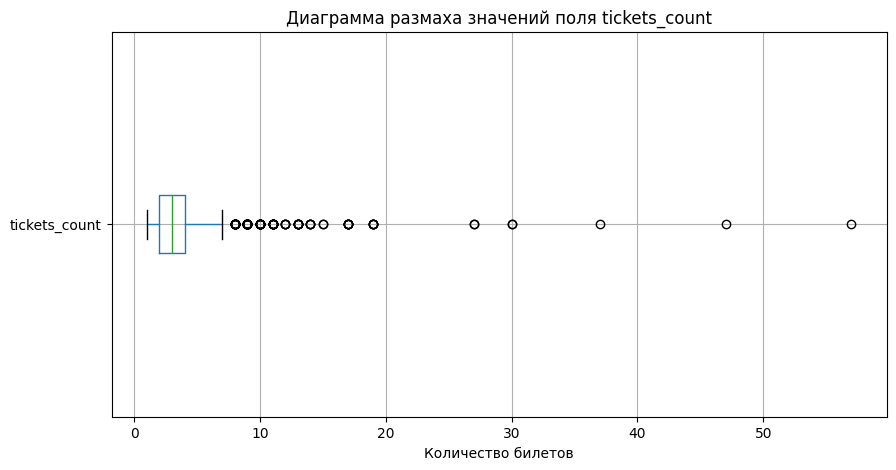

In [11]:
# Построим диаграмму размаха значений поля tickets_count
orders.boxplot(
    column='tickets_count',
    vert=False,
    figsize=(10,5))

plt.title('Диаграмма размаха значений поля tickets_count')
plt.xlabel('Количество билетов')
plt.show()

**Промежуточный вывод:** Максимальное количество билетов сильно сдвинуто вправо, что указывает на выброс. 75-ый процентиль равен 4, что так же говорит о выбросе. Отфильтруем датафрейм по 99-му процентилю чтобы избавиться от выбросов и не искажать будущие релзультаты анализа.

In [12]:
# Произведем филтрацию по полю tickets_count
orders = orders[orders['tickets_count'] < orders['tickets_count'].quantile(0.99)]

# Выведем еще раз описательную статистику поля 
orders['tickets_count'].describe()

count    286377.000000
mean          2.700660
std           1.080427
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           5.000000
Name: tickets_count, dtype: float64

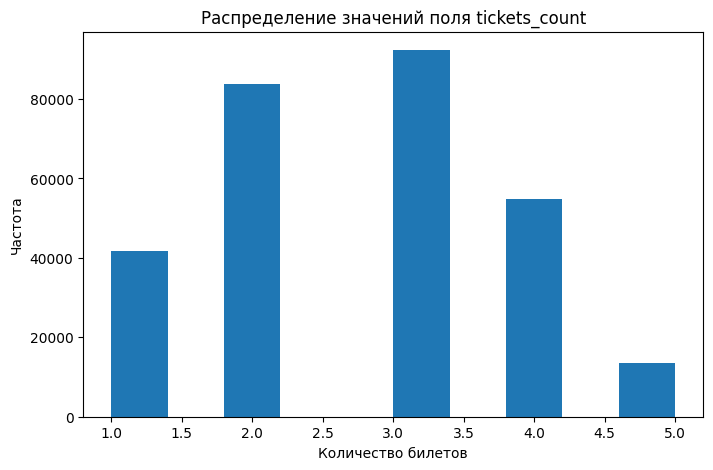

In [13]:
# Построим гистограмму распределения значений поля tickets_count
orders['tickets_count'].hist(
    figsize=(8,5)
)
plt.title('Распределение значений поля tickets_count')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.grid(False)
plt.show()

Описательная статистика и гистограмма распределения показывают, что теперь распределение количества билетов выглядит логично.

#### Рассмотрим поле `revenue`

Т.к в поле `revenue` содержатся значения в разных валютах (рубли и тенге), разделим датафрейм на два отдельных, чтобы значения не влияли друг на друга.

In [14]:
# Разделим датафреймы по валюте
orders_rub = orders[orders['currency_code'] == 'rub'].copy()
orders_kzt = orders[orders['currency_code'] == 'kzt'].copy()

Теперь выведем распределение значений поля `revenue` для каждой валюты. 

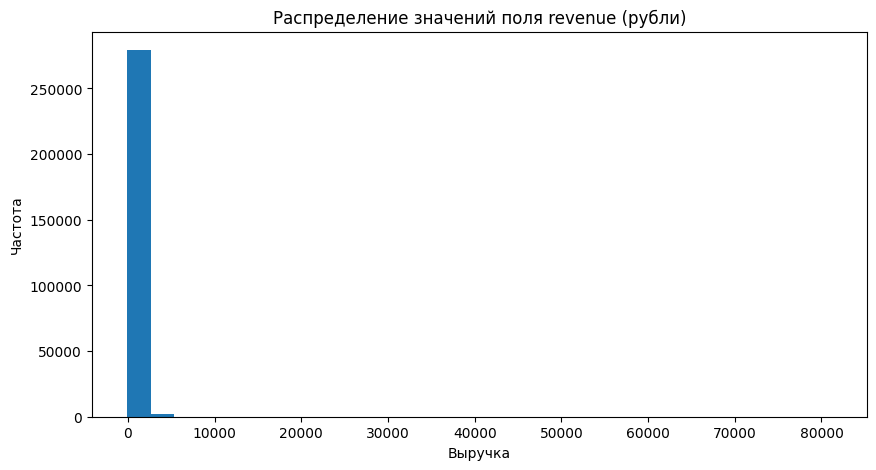

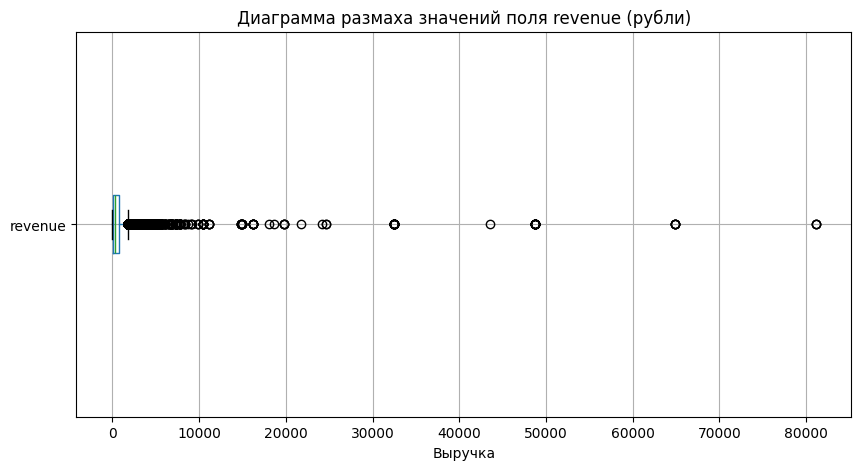

In [15]:
# Построим гистограмму распределения значений поля revenue
orders_rub['revenue'].hist(
    figsize=(10,5),
    bins=30
)
plt.title('Распределение значений поля revenue (рубли)')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(False)
plt.show()

# Построим диаграмму размаха значений поля revenue
orders_rub.boxplot(
    column='revenue',
    vert=False,
    figsize=(10,5))

plt.title('Диаграмма размаха значений поля revenue (рубли)')
plt.xlabel('Выручка')
plt.show()

In [16]:
# Выведем описательную статистику столбца revenue
orders_rub['revenue'].describe()

count    281377.000000
mean        539.408746
std         865.927906
min         -90.760000
25%         111.790000
50%         342.880000
75%         788.640000
max       81174.540000
Name: revenue, dtype: float64

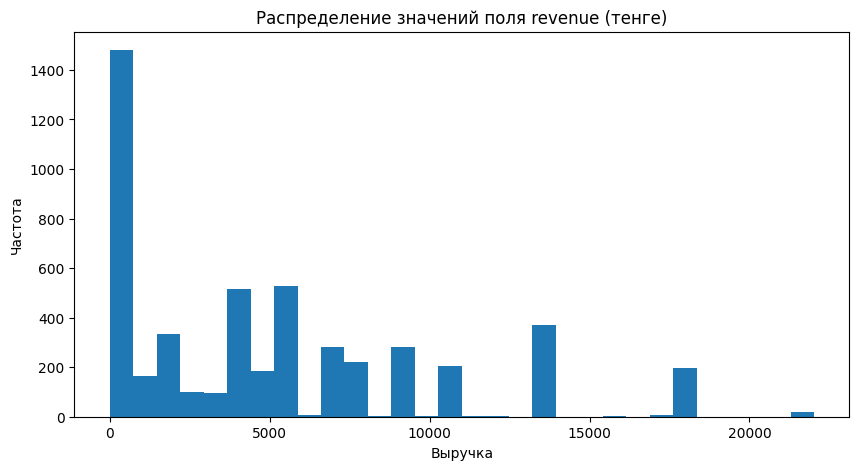

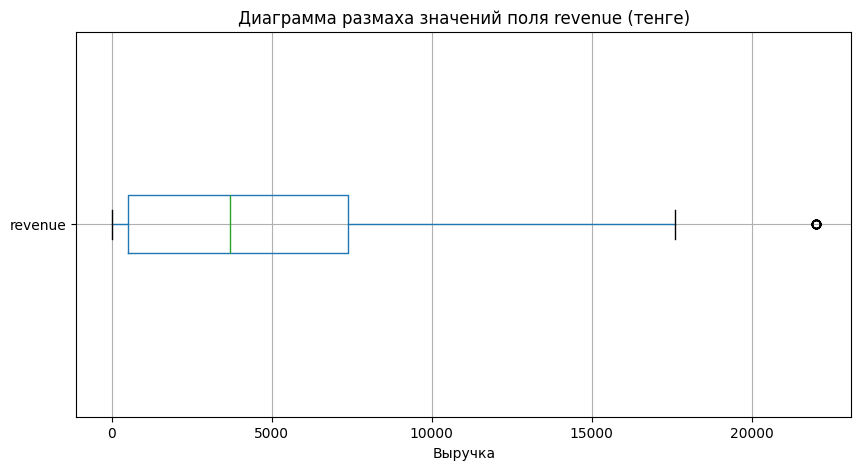

In [17]:
# Построим гистограмму распределения значений поля revenue
orders_kzt['revenue'].hist(
    figsize=(10,5),
    bins=30
)
plt.title('Распределение значений поля revenue (тенге)')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(False)
plt.show()

# Построим диаграмму размаха значений поля revenue
orders_kzt.boxplot(
    column='revenue',
    vert=False,
    figsize=(10,5))

plt.title('Диаграмма размаха значений поля revenue (тенге)')
plt.xlabel('Выручка')
plt.show()

In [18]:
# Выведем описательную статистику столбца revenue
orders_kzt['revenue'].describe()

count     5000.000000
mean      4993.767928
std       4860.891929
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      22021.550000
Name: revenue, dtype: float64

В поле `revenue` для обеих валют найдены выбросы по максимальному и минимальному (отрицательному) значениям. 

Для валюты в **рублях** найдены выбросы:
- минимальное значение: -90 (не может быть отрицательным)
- среднее: 539
- медиана: 342
- стандартное отклонение: 865
- максимальное: 81174.

Для валюты в **тенге** найдены выбросы:
- минимальное значение: 0
- среднее: 4993
- медиана: 3698
- стандартное отклонение: 4860
- максимальное: 22021.

**Промежуточный итог**

В обеих выборках по полю `revenue` стандартное отклонение выше среднего, что подтверждает наличие выбросов. В выборке с рублями также найдены отрицательные значения, что очевидно, ошибка в данных. Чтобы нормализовать данные, отфильтруем значения в обеих группах по 99-му процентилю (так же уберем отрицательные значения в рублях).

#### Объединим полученные датафреймы в один

In [19]:
# Посчитаем количество строк в обеих выборках до фильтрации
initial_count_rub = orders_rub.shape[0]
initial_count_kzt = orders_kzt.shape[0]

# Отфильтруем выборки
orders_rub = orders_rub[(orders_rub['revenue'] < orders_rub['revenue'].quantile(0.99)) &
                        (orders_rub['revenue'] >= 0)]

orders_kzt = orders_kzt[orders_kzt['revenue'] < orders_kzt['revenue'].quantile(0.99)]

# Посчитаем количество строк в выборках после фильтрации
final_count_rub = orders_rub.shape[0]
final_count_kzt = orders_kzt.shape[0]

# Найдем долю удаленных значений
share_rub = (1 - final_count_rub / initial_count_rub) * 100
share_kzt = (1 - final_count_kzt / initial_count_kzt) * 100

# Выведем результат
print(f'Из выборки с рублями удалено {initial_count_rub - final_count_rub} значений (в долях: {round(share_rub,2)}%)')
print(f'Из выборки с тенге удалено {initial_count_kzt - final_count_kzt} значений (в долях: {round(share_kzt,2)}%)')

Из выборки с рублями удалено 3208 значений (в долях: 1.14%)
Из выборки с тенге удалено 217 значений (в долях: 4.34%)


Объединим полученные группы обратно в один датафрейм `orders`:

In [20]:
# Объединяем выборки по валютам
orders_filter = pd.concat([orders_rub, orders_kzt])

# Выводим получившийся результат
display(orders_filter)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290722,6862648,ffc24188a1d58f2,2024-07-11,2024-07-11 12:39:48,538828,нет,12,kzt,mobile,4735.52,Билеты без проблем,2,67650.36,20.0
290723,6763294,ffc24188a1d58f2,2024-09-05,2024-09-05 12:07:00,538828,нет,12,kzt,mobile,4735.52,Билеты без проблем,2,67650.36,56.0
290724,3984021,ffc24188a1d58f2,2024-09-06,2024-09-06 19:20:03,533803,нет,16,kzt,mobile,1849.41,Мой билет,1,30823.58,1.0
290726,8493869,ffc4133fbba20f4,2024-06-21,2024-06-21 14:04:34,533803,нет,16,kzt,mobile,3698.83,Мой билет,2,61647.16,NaN


### Проверка на явные и неявные дубликаты

#### Проверим датафрейм на наличие явных дубликатов

In [21]:
# Найдем явные дубликаты
duplicates_num = orders_filter.duplicated().sum()
print(f'В датафрейме {duplicates_num} явных дубликатов')

В датафрейме 0 явных дубликатов


Теперь попробуем найти неявные дубликаты по бронированю билетов, без учета идентификаторов заказа:

In [22]:
# Создаем список полей без order_id
list_dup = []
for _ in orders_filter.columns: 
    if _ != 'order_id': list_dup.append(_)
        
# Найдем неявные дубликаты
duplicates = orders_filter[orders_filter.duplicated(subset=list_dup, keep=False)]

# Посчитаем долю пропусков
shape = round((duplicates.shape[0] / orders_filter.shape[0]) * 100,3)

#orders_filter.duplicated(subset=list_dup).sum()
print(f'Найдено {duplicates.shape[0]} неявных дубликатов')
print(f'Доля пропусков {shape}%')

Найдено 58 неявных дубликатов
Доля пропусков 0.02%


In [23]:
# Выведем полученные дубликаты и оценим их
display(duplicates)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0
148473,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0
154170,5372628,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0


Найденные неявные дубликаты повторяются по полям, важным для анализа `revenue`, `tickets_count`. Чтобы не искажать результаты исследования, можно удалить дубликаты, т.к их доля крайне мала - всего 0.02%.

In [24]:
# Удаляем все неявные дубликаты
orders_filter.drop_duplicates(subset=list_dup, keep=False, inplace=True)

### Преобразование типов данных

#### Рассмотрим датафрейм `orders_filter`

In [25]:
# Выведем типы данных в датафрейме orders_filter
print(orders_filter.dtypes)

order_id                   int64
user_id                   object
created_dt_msk            object
created_ts_msk            object
event_id                   int64
cinema_circuit            object
age_limit                  int64
currency_code             object
device_type_canonical     object
revenue                  float64
service_name              object
tickets_count              int64
total                    float64
days_since_prev          float64
dtype: object


- поля `created_dt_msk` и `created_ts_msk` следует преобразовать к типу *datetime*. 
- поля с числами стоит попробовать преобразовать к меньшей разрядности для экономии памяти.

In [26]:
# Преобразуем поля с датами к типу datetime
orders_filter['created_dt_msk'] = pd.to_datetime(orders_filter['created_dt_msk'])
orders_filter['created_ts_msk'] = pd.to_datetime(orders_filter['created_ts_msk'])

# Попробуем понизить размерность в столбцах с типом int64
int_convert = ['order_id', 'event_id', 'age_limit', 'tickets_count']
orders_filter[int_convert] = orders_filter[int_convert].apply(pd.to_numeric, downcast='integer')

# Попробуем понизить размерность в столбцах с типом float64
float_convert = ['revenue', 'total', 'days_since_prev']
orders_filter[int_convert] = orders_filter[int_convert].apply(pd.to_numeric, downcast='float')

#### Рассмотрим датафрейм `events`

In [27]:
# Выведем типы данных в датафрейме events
print(events.dtypes)

event_id                   int64
event_name                object
event_type_description    object
event_type_main           object
organizers                object
region_name               object
city_name                 object
city_id                    int64
venue_id                   int64
venue_name                object
venue_address             object
dtype: object


In [28]:
# Попробуем понизить размерность в столбцах с типом int64
int_convert = ['event_id', 'city_id', 'venue_id']
events[int_convert] = events[int_convert].apply(pd.to_numeric, downcast='integer')

#### Рассмотрим датафрейм `tenge`

In [29]:
# Выведем типы данных в датафрейме tenge
print(tenge.dtypes)

data        object
nominal      int64
curs       float64
cdx         object
dtype: object


In [30]:
# Приведем столбец data к нужному типу
tenge['data'] = pd.to_datetime(tenge['data'])

# Попробуем понизить размерность в столбцах с типом int64 и float64
tenge['nominal'] = tenge['nominal'].apply(pd.to_numeric, downcast='integer')
tenge['curs'] = tenge['curs'].apply(pd.to_numeric, downcast='float')

### Создание новых столбцов

Для дальнейшей работы объединим все датафреймы в один:

In [31]:
# Объединим датафреймы orders_filter и events в df
df = pd.merge(orders_filter, events, on='event_id', how='left')
# Присоединим к df таблицу tenge
df = df.merge(tenge, left_on='created_dt_msk', right_on='data', how='left')

Перейдем к созданию новых столбцов:
- `revenue_rub` - выручка тенге переведенная в рубли
- `one_ticket_revenue_rub` - рассчитанная выручка с продажи одного билета
- `month` - месяц оформления заказа
- `season` - столбец, содержащий информацию о сезонности включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

#### Создание столбца `revenue_rub`

In [32]:
# Напишем функцию, которая будет переводить выручку только в тенге
def kzt_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] / row['nominal'] * row['curs']
    else:
        return row['revenue']

# Создадим новый столбец
df['revenue_rub'] = df.apply(kzt_to_rub, axis=1)

#### Создание столбца `one_ticket_revenue_rub`

In [33]:
df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']

#### Создание столбца `month`

In [34]:
df['month'] = df['created_dt_msk'].dt.month

#### Создание столбца `season`

In [35]:
# Напишем функцию, которая будет выделять сезон по месяцу
def season(row):
    if row['month'] in (3,4,5):
        return 'весна'
    elif row['month'] in (6,7,8):
        return 'лето'
    elif row['month'] in (9,10,11):
        return 'осень'
    else:
        return 'зима'

# Создадим столбец
df['season'] = df.apply(season,axis=1)

**Итоговый вывод:** 
- В категориальных полях не обранурежно повторяющихся и аномальных значений.
- Из-за наличия выбросов в полях `tickets_count` и `revenue` датафрейм был отфильтрован по 99-му процентилю, а так же были убраны невозможные отрицательные значения. Для корректного поиска выбросов датафрейм был разделен по валюте на два отдельных (выручка в рублях и тенге). Затем, отфильтрованные датафреймы были объединены в один `orders_filter`.
- Датафрейм `orders_filter` был очищен от явных и неявных дубликатов по всем полям, кроме `order_id`.
- Поля в датафреймах `orders_filter`, `events` и `tenge` были приведены к корректному типу. В численных полях, где это было возможно, была понижена разрядность для уменьшения затрат памяти.
- Были созданы новые поля в датафрейме `orders_filter`:
    - `revenue_rub` - выручка в рублях (с помощью таблицы `tenge`).
    - `one_ticket_revenue_rub` - выручка с одного билета.
    - `month` - выделенный месяц из поля с датой.
    - `season` - выделенное время года из поля с датой.

## Предобработка данных и подгтовка к исследованию

### Анализ распределения заказов по сегментам и их сезонных изменений

Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается. Необходимо изучить изменение пользовательской активности или пользовательского интереса в связи с сезонностью. 

Проанализируем динамику по таким разрезам:
- тип мероприятия `event_type_main`;
- тип устройства `device_type_canonical`;
- категория мероприятий по возрастному рейтингу `age_limit`.

#### Поиск количества заказов по месяцам

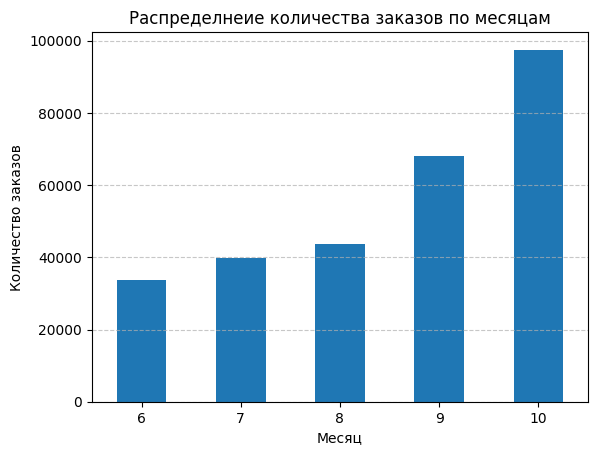

In [36]:
# Сгруппируем количество билетов по месяцам
orders_per_month = df.groupby('month')['order_id'].count()

# Построим столбчатую диаграмму
orders_per_month.plot(
    kind='bar',
    rot=0
)

plt.title('Распределнеие количества заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Распределение заказов за осенний и летний период

In [37]:
# Посчитаем общее количество заказов за период
total_orders_per_season = df.groupby('season')['order_id'].count()

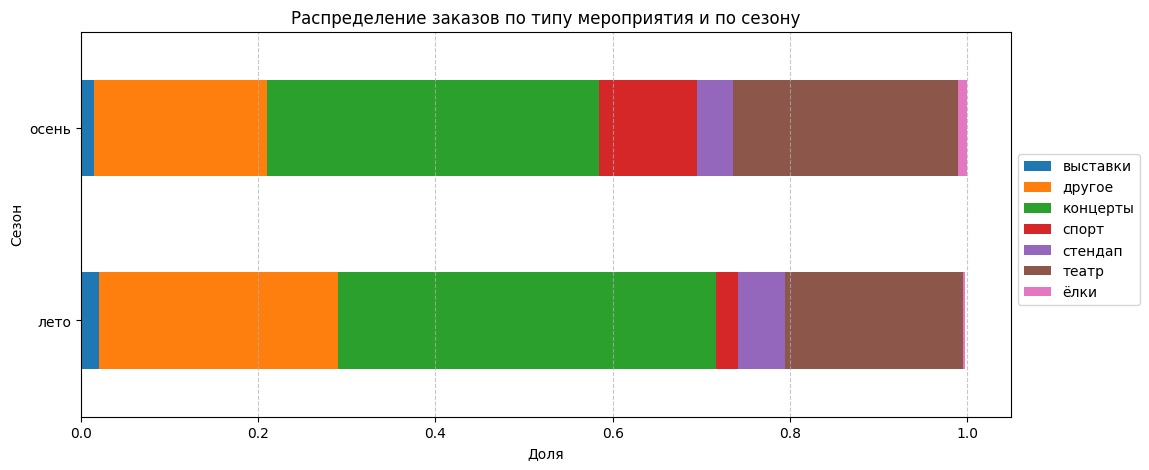

In [38]:
# Распределение заказов по типу мероприятия в долях
orders_per_season_type = (df.groupby(['season', 'event_type_main'])['order_id'].count() / total_orders_per_season)

# Построим график
orders_per_season_type.unstack().plot(kind='barh', figsize=(12,5), rot=0, stacked=True)

plt.title('Распределение заказов по типу мероприятия и по сезону')
plt.xlabel('Доля')
plt.ylabel('Сезон')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1, 0.7))
plt.show()

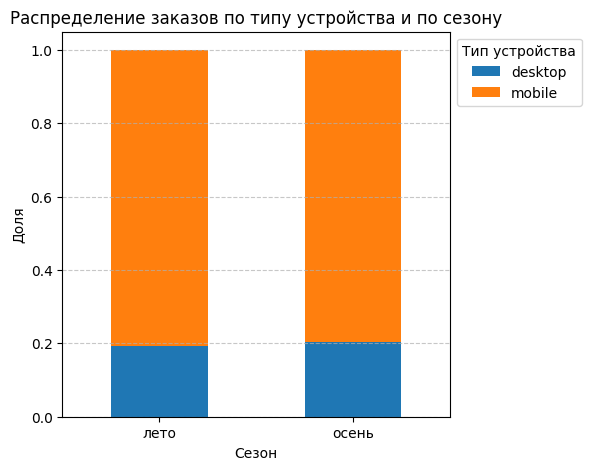

In [39]:
# Распределение заказов по типу устройства в долях
orders_per_season_device = df.groupby(['season', 'device_type_canonical'])['order_id'].count() / total_orders_per_season

# Построим график
orders_per_season_device.unstack().plot(kind='bar', figsize=(5,5), rot=0, stacked=True)

plt.title('Распределение заказов по типу устройства и по сезону')
plt.xlabel('Сезон')
plt.ylabel('Доля')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1, 1), title='Тип устройства')
plt.show()

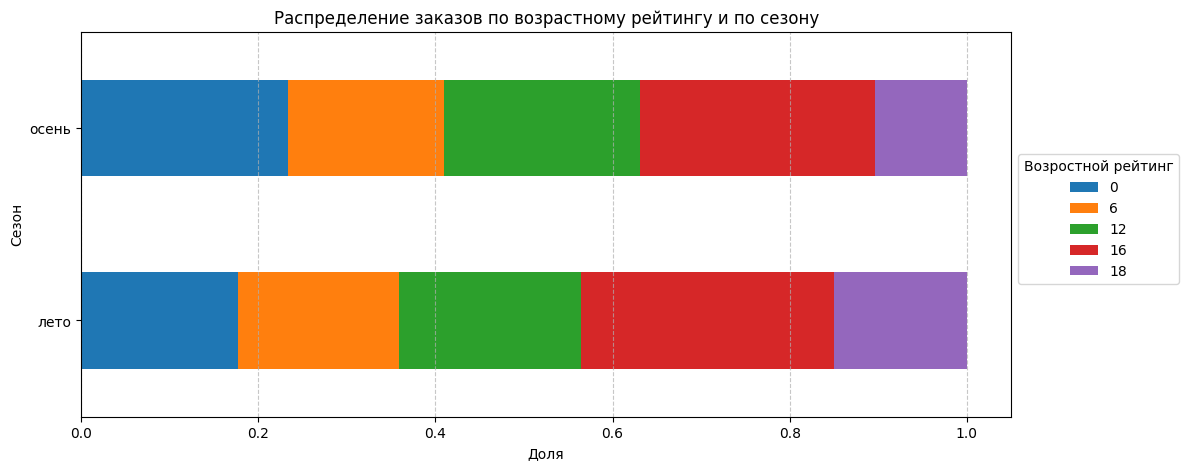

In [40]:
# Распределение заказов по возрастной группе в долях
orders_per_season_age = df.groupby(['season', 'age_limit'])['order_id'].count() / total_orders_per_season

# Построим график
orders_per_season_age.unstack().plot(kind='barh', figsize=(12,5), rot=0, stacked=True)

plt.title('Распределение заказов по возрастному рейтингу и по сезону')
plt.xlabel('Доля')
plt.ylabel('Сезон')
plt.legend(bbox_to_anchor=(1, 0.7), title='Возростной рейтинг')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Изменение выручки с продажи одного билета

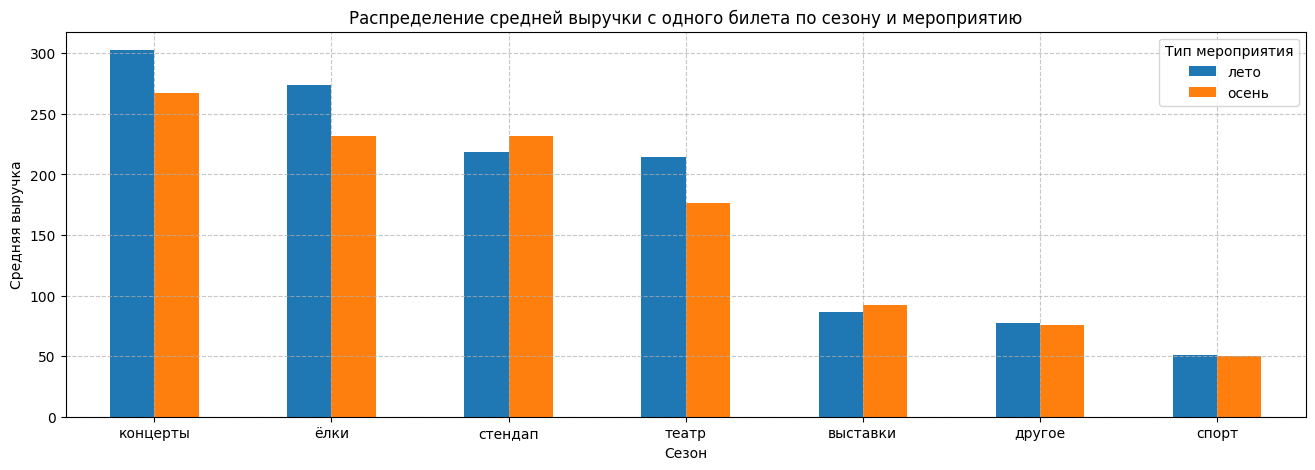

In [41]:
# Сгруппируем данные по сезону и типу мероприятия и надем значение средней выручки с одного билета
revenue_per_season = df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack(fill_value=0)

#Сбросим индекс и проведем сортировку по значению средней выручки
revenue_per_season = revenue_per_season.reset_index()
revenue_per_season = revenue_per_season.sort_values(by='лето',ascending=False)

# Построим график
revenue_per_season.plot(kind='bar', figsize=(16,5), rot=0, x='event_type_main')

plt.title('Распределение средней выручки с одного билета по сезону и мероприятию')
plt.xlabel('Сезон')
plt.ylabel('Средняя выручка')
plt.legend(bbox_to_anchor=(1, 1), title='Тип мероприятия')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

#### Промежуточные выводы

- C наступлением осени общее количество заказов увеличивается. 
- Самыми популярными категориями остаются театры, концерты и "другое", вне зависимости от сезона. Стоит отметить, что доля спортивных мероприятий осенью увеличивается.
- Распределение заказов по типу устройств для каждого сезона остается практически одинаковым.
- Распределение заказов по возрастному рейтингу в каждом сезоне примерно одинаковое. Летом большую часть занимают взрослые мероприятия 16+ и 18+, а осенью становятся пополярнее детские мероприятия 0+ и 6+.
- Распределение средней выручки показывает схожие показатели для каждого сезона. Самыми выгодными для обоих сезонов являются концерты, самыми невыгодными - спортивные мероприятия.

### Осенняя активность пользователей

#### Анализ динамики изменений по дням для показателей:
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

In [42]:
# Отберем необходимые данные только за осенний период
df_autumn = df[df['season'] == 'осень'][['order_id', 'user_id', 'created_dt_msk', 'one_ticket_revenue_rub']]

In [43]:
# Создадим сводную таблицу и посчитаем количетсво заказов, DAU 
# и среднюю стоимость одного билета 
pivot = df_autumn.groupby('created_dt_msk').agg({
    'order_id' : 'count',
    'user_id' : 'nunique',
    'one_ticket_revenue_rub' : 'median'
}).reset_index()

# Переименуем столбцы
pivot = pivot.rename(
    columns={
    'created_dt_msk' : 'date',
    'order_id' : 'orders',
    'user_id' : 'DAU'}
)

# Найдем среднее количество заказов на пользователя
pivot['orders_per_users'] = pivot['orders'] / pivot['DAU']

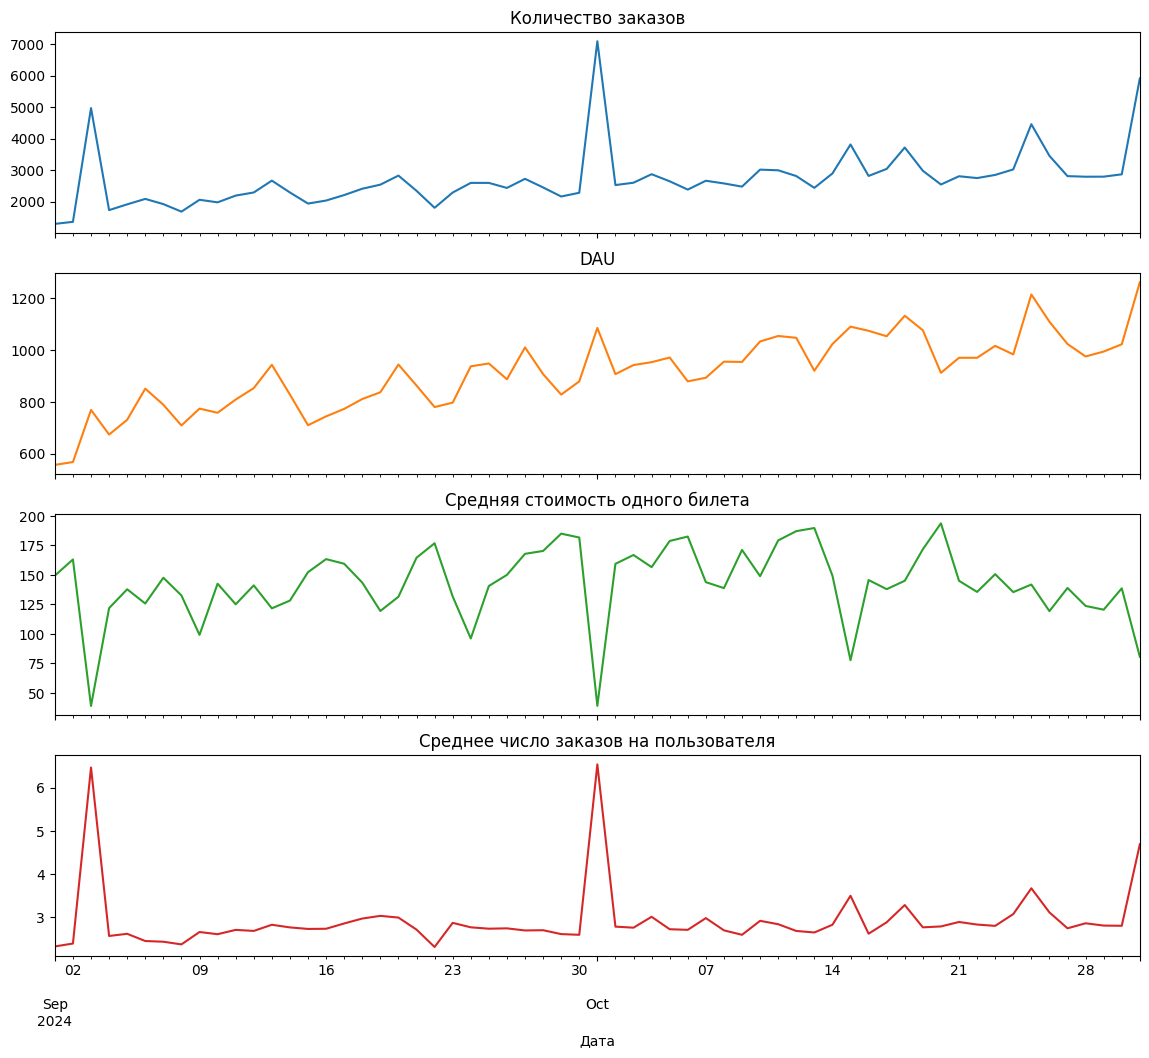

In [44]:
# Строим графики распределения показателей
pivot.plot(kind='line', x='date', subplots=True, sharex=True, sharey=False, figsize=(14,12), legend=False,
          title=['Количество заказов', 'DAU', 'Средняя стоимость одного билета', 'Среднее число заказов на пользователя'])

plt.xlabel('Дата')
plt.show()

#### Недельная цикличность

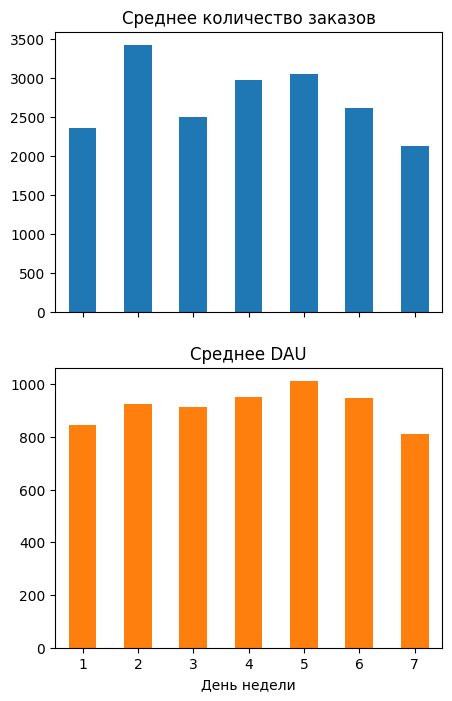

In [45]:
# Найдем день недели
pivot['day_of_week'] = pivot['date'].dt.day_of_week + 1

# Сгруппируем данные по дню недели и рассчитаем средние показатели активности
day_activity = pivot.groupby('day_of_week').agg(mean_orders=('orders', 'mean'), mean_DAU=('DAU', 'mean')).reset_index()

# Построим графики
day_activity.plot(kind='bar', x='day_of_week', rot=0, subplots=True, sharex=True, sharey=False, legend=False,
                 figsize=(5,8), title=['Среднее количество заказов', 'Среднее DAU'])

plt.xlabel('День недели')
plt.show()

#### Промежуточные выводы

Анализируя первую группу графиков , можно сделать следущие выводы:
- Количество заказов демонстрирует всплески, что может быть связано с сезонными акциями или конкретными событиями.
- DAU постепенно увеличивается, что может означать рост интереса пользователей к сервису или увеличивающееся количество пользователей.
- Средняя стоимость одного билета показывает довольно ровную динамику с незначительными колебаниями, что может указывать на стабильность ценовой политики. 
- Среднее количество заказов на пользователя демонстрирует более значительные колебания, что может быть связано с активными пользователями, которые делают больше заказов в определенные периоды времени.

По графикам второй группы видно, что среднее количество заказов максимально во второй день недели, а среднее DAU в пятый день. В выходные (6 и 7 дни недели) оба показателя снижаются. Наименьшие значения по обоим метрикам наблюдаются в воскресенье.

### Популярные события и партнёры

#### Для каждого региона

In [46]:
# Посчитаем для каждого региона количество уникальных событий и общее количество заказов
top_region = df.groupby('region_name').agg({
    'event_id' : 'nunique',
    'order_id' : 'count'
}).reset_index()

# Переименуем столбцы
top_region = top_region.rename(columns={'event_id' : 'events', 'order_id' : 'orders'})

# Найдем общее количество событий и заказов для расчета долей
all_events = top_region['events'].sum()
all_orders = top_region['orders'].sum()

# Посчитаем доли событий и заказов
top_region['events_perc'] = top_region['events'] / all_events * 100
top_region['orders_perc'] = top_region['orders'] / all_orders * 100

# Установим название регионов как индексы
top_region.set_index('region_name', inplace=True)

# Остортируем выборку по доле мероприятий 
top_region.sort_values(by='events_perc', ascending=False, inplace=True)

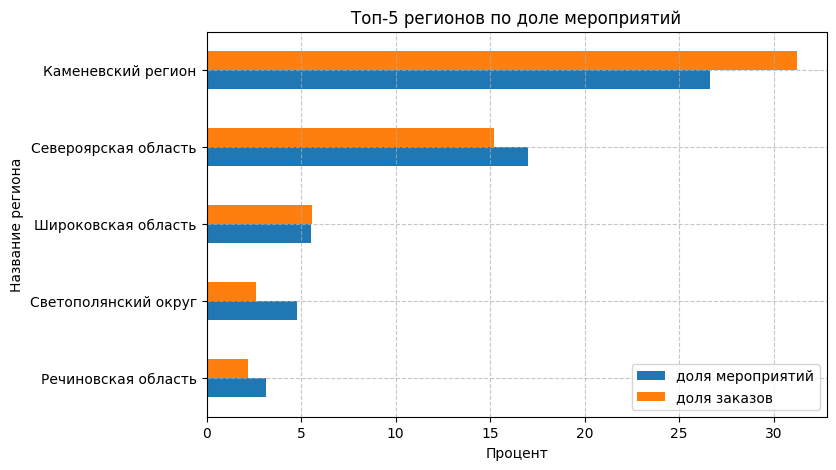

In [47]:
# Отберем топ-5 регионов по доле мероприятий из таблицы top_region
# для построения графика
top_region_graph = top_region[['events_perc', 'orders_perc']].head(5).reset_index().sort_values(by='events_perc')

# Переименуем столбцы
top_region_graph = top_region_graph.rename(columns={'events_perc' : 'доля мероприятий',
                                                    'orders_perc' : 'доля заказов'})

# Построим график
top_region_graph.plot(kind='barh', x='region_name', figsize=(8,5))

plt.title('Топ-5 регионов по доле мероприятий')
plt.xlabel('Процент')
plt.ylabel('Название региона')
plt.grid(linestyle='--', alpha=0.7)

plt.show()

#### Для каждого билетного партнёра

In [48]:
top_partner = df.groupby('service_name').agg({
    'event_id' : 'nunique',
    'order_id' : 'count',
    'revenue_rub' : 'sum'
}).reset_index()

top_partner = top_partner.rename(columns={'event_id' : 'events', 'order_id' : 'orders'})

all_events = top_partner['events'].sum()
all_orders = top_partner['orders'].sum()

top_partner['events_perc'] = top_partner['events'] / all_events * 100
top_partner['orders_perc'] = top_partner['orders'] / all_orders * 100

top_partner.sort_values(by='revenue_rub', ascending=False, inplace=True)
top_partner.set_index('service_name', inplace=True)

top_partner.head(10)

,events,orders,revenue_rub,events_perc,orders_perc
service_name,,,,,
Билеты без проблем,4198,61627,2.340137e+07,17.338510,21.784485
Мой билет,1292,33808,2.085144e+07,5.336197,11.950766
Облачко,2322,26143,1.818984e+07,9.590286,9.241271
Лови билет!,4836,40133,1.616223e+07,19.973567,14.186586
Весь в билетах,850,16140,1.595420e+07,3.510656,5.705317
Билеты в руки,3507,39509,1.277770e+07,14.484553,13.966008
Край билетов,250,6027,6.250461e+06,1.032546,2.130480
Прачечная,1023,10050,4.611859e+06,4.225178,3.552567
Дом культуры,272,4358,4.253967e+06,1.123410,1.540506


#### Промежуточный вывод

**Регоионы:** Лидером среди всех регионов является Каменевский регион - около 27% всех событий и более 31% всех заказов. Второй по показателям регион - Североярская область, на нее прходится 17% событий и 15% заказов (почти в 2 раза меньше, чем первый регион.)

**Партнеры:** Лидером среди партнеров является сервис "Билеты без проблем" - 17% всех событий и 21% всех заказов, а также этот регион принес максимальную выручку - более 23 млн рублей. 

## Статистический анализ данных

Перед анализом необходимо сформулировать гипотезы:

1. Гипотеза о среднем числе заказов на пользователя

- Нулевая гипотеза (H0): Среднее количество заказов на одного пользователя у мобильного приложения не выше (меньше или равно), чем у пользователей стационарных устройств (H0: μA >= μB).
- Альтернативная гипотеза (H1): Среднее количество заказов на одного пользователя у мобильного приложения выше, чем у пользователей стационарных устройств (H1: μA < μB).

2. Гипотеза о среднем времени между заказами на пользователя

- Нулевая гипотеза (H0): Среднее время между заказами у пользователей мобильного приложения не выше (меньше или равно), чем у пользователей стационарных устройств (H0: μA >= μB).
- Альтернативная гипотеза (H1): Среднее время между заказами у пользователей мобильного приложения ниже, чем у пользователей стационарных устройств (H1: μA < μB).

Главными метриками для обоих тестов будут:

- Среднее количество заказов.
- Среднее время между заказами.

Чтобы приступить к проверке гипотез, необходимо сформировать выборки из общего датафрейма и сравнить их. Общий датафрейм готов к тесту:
- Пропусков нет, дубликаты удалены.
- Аномалии и выбросы обработаны.

### Подготовка к тестам

Сформируем выборки по типам устройств и сравним их. Для начала, необходимо выбрать из общей таблицы людей, которые пользуются **только одним** устройством, чтобы выборки были независимы.

In [49]:
# Отберем группы из общей таблицы
group_A = df[(df['device_type_canonical'] == 'desktop') & (df['season'] == 'осень')]
group_B = df[(df['device_type_canonical'] == 'mobile') & (df['season'] == 'осень')]

# Попробуем найти пользователей, которые могли оказаться в обеих группах
# для этого выделим всех пользователей в обеих группах
users_desktop, users_mobile = group_A['user_id'].unique(), group_B['user_id'].unique()

# Найдем пользователей в обеих группах и выведем их количество 
intersection = list(set(users_mobile) & set(users_desktop))
print('Пользователей в обеих группах:', len(intersection))

Пользователей в обеих группах: 3215


В обеих группах нашлись общие пользователи, удалим их, чтобы выборки стали независимыми:

In [50]:
# Удалим из выборок пользователей, которые присутствуют в обеих группах
group_A = group_A[~group_A['user_id'].isin(intersection)]
group_B = group_B[~group_B['user_id'].isin(intersection)]

### Среднее количество заказов

In [51]:
# Сравним выборки между собой по количеству наблюдений
print(f'В группе А: {group_A.shape[0]} наблюдений')
print(f'В группе В: {group_B.shape[0]} наблюдений')

В группе А: 3158 наблюдений
В группе В: 30830 наблюдений


Количества наблюдений достаточно в обеих группах. При этом, в группе А (стационарные устройства) значительно меньше наблюдений, чем в группе В (мобильные устройства). Посмотрим на распределение среднего числа заказов на пользователя:

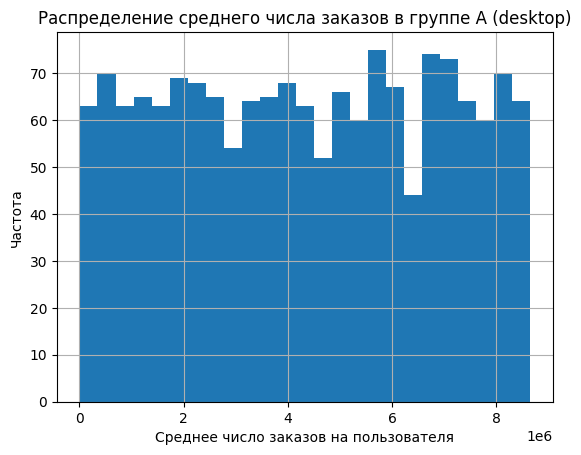

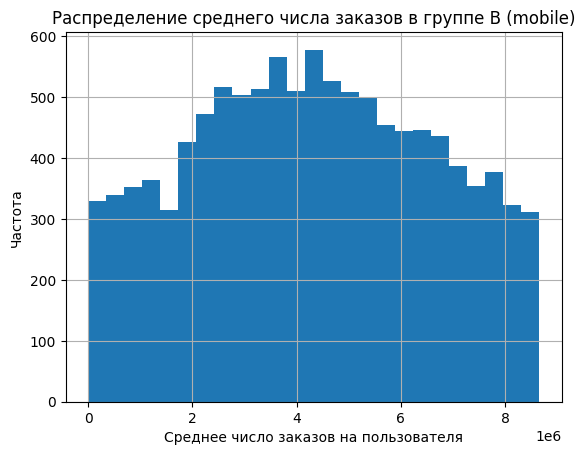

In [52]:
# Посчитаем выборочные средние каждой группы
test_A = group_A.groupby('user_id')['order_id'].mean()
test_B = group_B.groupby('user_id')['order_id'].mean()

# Построим гистограмму распределения выборочного среднего
test_A.hist(bins=25)
plt.title('Распределение среднего числа заказов в группе А (desktop)')
plt.xlabel('Среднее число заказов на пользователя')
plt.ylabel('Частота')
plt.show()

test_B.hist(bins=25)
plt.title('Распределение среднего числа заказов в группе B (mobile)')
plt.xlabel('Среднее число заказов на пользователя')
plt.ylabel('Частота')
plt.show()

Проверим нормальность распределения в группах с помощью теста Шапиро-Уилка:

In [53]:
# Проведем тест Шапиро_Уилка
stat_A, p_A = shapiro(test_A)
stat_B, p_B = shapiro(test_B)

print(f'pvalue группы А: {p_A}')
print(f'pvalue группы В: {p_B}')
print()

if (p_A > 0.05):
    print('Данные в группе А распределены нормально')
else:
    print('Данные в группе А распределены не нормально')
    
if (p_B > 0.05):
    print('Данные в группе B распределены нормально')
else:
    print('Данные в группе B распределены не нормально')

pvalue группы А: 2.0310220951715528e-22
pvalue группы В: 5.22720935444244e-41

Данные в группе А распределены не нормально
Данные в группе B распределены не нормально


C:\Users\sereg\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10860.
  res = hypotest_fun_out(*samples, **kwds)


Проверим группы на равенство дисперсий с помощью теста Леване:

In [54]:
# Проведем тест Леване
stat, pvalue = levene(test_A, test_B)
print(f'pvalue = {pvalue}')
if pvalue > 0.05:
    print('Дисперсии выборок равны')
else:
    print('Дисперсии выборок различаются')

pvalue = 9.117680450455944e-14
Дисперсии выборок различаются


В обеих группах отсутсвует нормальное распределение данных и различаются дисперсии, поэтому проверки гипотезы используем непараметрический тест Манна-Уитни, который не требует соблюдения этих условий.

In [55]:
# Проводим тест 
mw_test = mannwhitneyu(
    test_A,
    test_B,
    alternative='greater'
)

# Задаем уровень значимости
alpha = 0.05

# Проверяем гипотезы
if mw_test.pvalue > 0.05:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Среднее число заказов на одного пользователя у мобильного приложения не выше, чем у пользователей стационарных устройств ')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Среднее число заказов на одного пользователя у мобильного приложения выше, чем у пользователей стационарных устройств ')

pvalue=0.42463246404501964 > 0.05
Среднее число заказов на одного пользователя у мобильного приложения не выше, чем у пользователей стационарных устройств 


### Среднее время между заказами

Посчитаем разницу во времени для каждого пользователя в обеих группах:

In [56]:
# Отсортируем выборки по возрастанию по дате заказа для каждого пользователя
group_A = group_A.sort_values(by=['user_id', 'created_ts_msk'])
group_B = group_B.sort_values(by=['user_id', 'created_ts_msk'])

# Посчитаем разницу между заказами для каждого пользователя
group_A['time_diff'] = group_A.groupby('user_id')['created_ts_msk'].diff()
group_B['time_diff'] = group_B.groupby('user_id')['created_ts_msk'].diff()

# Переведем полученную разницу в секунды, чтобы рассчитать средние значения 
group_A['time_diff'] = group_A['time_diff'].dt.total_seconds()
group_B['time_diff'] = group_B['time_diff'].dt.total_seconds()

# Удаляем все нулевые значения
# Чтобы они не влияли на расчет среднего значения
group_A = group_A.dropna(subset=['time_diff'])
group_B = group_B.dropna(subset=['time_diff'])

In [57]:
# Сравним выборки между собой по количеству наблюдений
print(f'В группе А: {group_A.shape[0]} наблюдений')
print(f'В группе В: {group_B.shape[0]} наблюдений')

В группе А: 1549 наблюдений
В группе В: 19970 наблюдений


Количества наблюдений достаточно в обеих группах. При этом, в группе А (стационарные устройства) значительно меньше наблюдений, чем в группе В (мобильные устройства). Посмотрим на распределение среднего числа заказов на пользователя:

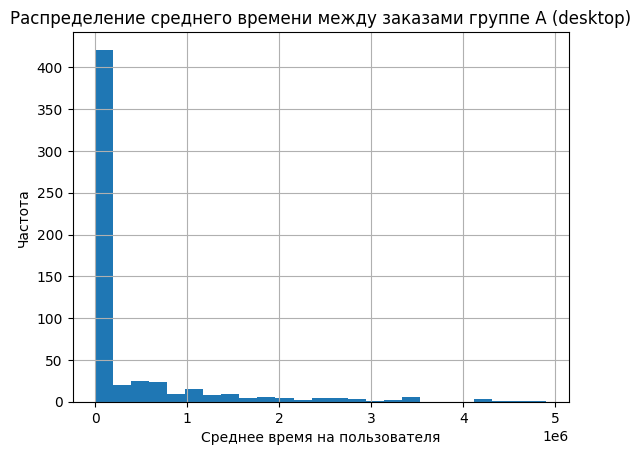

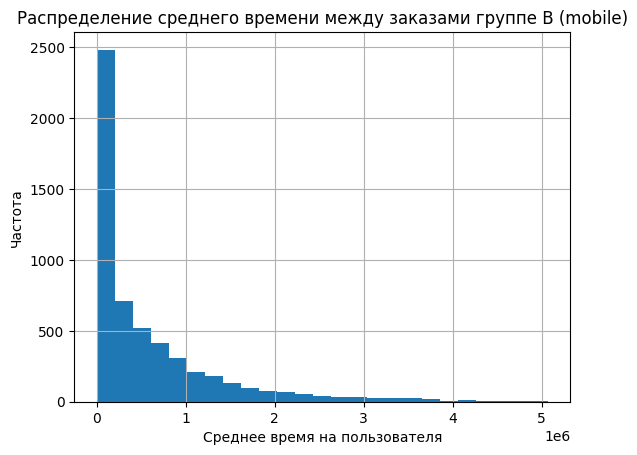

In [58]:
# Расчитаем средние значения 
test_A = group_A.groupby('user_id')['time_diff'].mean()
test_B = group_B.groupby('user_id')['time_diff'].mean()

# Построим гистограмму распределения выборочного среднего
test_A.hist(bins=25)
plt.title('Распределение среднего времени между заказами группе А (desktop)')
plt.xlabel('Среднее время на пользователя')
plt.ylabel('Частота')
plt.show()

test_B.hist(bins=25)
plt.title('Распределение среднего времени между заказами группе B (mobile)')
plt.xlabel('Среднее время на пользователя')
plt.ylabel('Частота')
plt.show()

Оба распределения не являются нормальным и в обоих наблюдаются выбросы. Чтобы проверить гипотезу стоит воспользоваться непараметрическим тестом Манна-Уитни:

In [59]:
# Проводим тест 
mw_test = mannwhitneyu(
    test_A,
    test_B,
    alternative='greater'
)

# Задаем уровень значимости
alpha = 0.05

# Проверяем гипотезы
if mw_test.pvalue > 0.05:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Среднее время между заказами на одного пользователя у мобильного приложения не выше, чем у пользователей стационарных устройств ')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Среднее время между заказами на одного пользователя у мобильного приложения выше, чем у пользователей стационарных устройств ')

pvalue=1.0 > 0.05
Среднее время между заказами на одного пользователя у мобильного приложения не выше, чем у пользователей стационарных устройств 


### Вывод

После проведения тестов обе гипотезы не нашли подтверждение. Значение pvalue в первом тесте равен 0.42, во втором 1.0. Это говорит о том, что обе гипотезы не находят подтверждение, а это значит что: 
- пользователи мобильных устройств **не заказывают** в среднем больше заказов, чем на пользователи стационарных устройств.
- среднее время между заказами у пользователей мобильных устройств **не выше**, чем у пользователей стационарных устройств.

## Общий вывод и рекомендации

### Информацию о данных

Для проведения исследовательского анализа были представлены основные таблицы с информацией о заказах и событиях, а также вспомогательная таблица с курсом валют тенге-рубль. Была проведена работа с пропусками, явными и неявными дубликаиами, типы данных приведены к подходящим, выбросы были обработаны. Перед анализом таблицы были объеденины в единый датафрейм, были сформированы новые столбцы, а поле с выручкой приведено к единой валюте - рубли.

### Основные результаты анализа
С наступлением осени общее количество заказов возрастает, что, вероятно, связано с возвращением аудитории к городским активностям после летнего отдыха. Наиболее востребованными категориями остаются театры, концерты и прочие события вне зависимости от времени года, однако осенью наблюдается заметное увеличение доли спортивных мероприятий, что может быть обусловлено стартом осенних спортивных сезонов.

Распределение заказов по типам устройств в разные сезоны практически не меняется — мобильные и стационарные пользователи демонстрируют схожую активность.

Средний чек на билет сохраняет стабильность на протяжении анализируемых периодов, средняя выручка за заказ колеблется незначительно. При этом наиболее выгодной категорией для сервиса остаются концерты, в то время как спортивные мероприятия приносят минимальную выручку на проданный билет.

Динамика пользовательской активности показывает, что общее количество заказов периодически демонстрирует всплески — их можно связать с акционными предложениями или крупными мероприятиями. Постепенный рост суточной аудитории (DAU) указывает как на приток новых пользователей, так и на увеличение вовлеченности текущей аудитории.

По дням недели максимальная пользовательская активность, выраженная в заказах, приходится на второй день недели, а пик дневной аудитории — на пятницу, после чего оба показателя снижаются в выходные, достигая минимума в воскресенье. Это может отражать предпочтения аудитории и специфику планирования досуга.

Среди регионов заметным лидером остается Каменевский регион с наибольшей долей событий и заказов (более четверти всех событий и трети заказов), второе место занимает Североярская область с гораздо более скромными показателями.

Среди партнеров лидирует сервис «Билеты без проблем», обеспечивший не только максимальное число заказов (21%), но и наибольшую выручку (23 млн рублей). Это партнер, на которого стоит делать ставку при заключении новых соглашений и реализации совместных кампаний.

### Результаты проверки гипотез

Результаты проверки гипотез статистически значимых отличий между пользователями мобильных и стационарных устройств не выявили: обе гипотезы отклонены (p-value: 0.42 и 1.0 соответственно). Пользователи мобильных устройств в среднем не совершают больше заказов, и интервал между заказами у них незначительно отличается от стационарных. Это указывает на однородность поведения аудитории по устройствам и отсутствие причины для выделения отдельных стратегий по разным платформам.

### Рекомендации

- Рассмотреть возножность увеличения вовлеченности пользователей к детским и спортивным мероприятиям, особенно в осенний сезон.
- Внедрить таргетированные маркетинговые кампании, ориентированные на аудиторию, интересующуюся театральными и концертными событиями, чтобы увеличить их востребованность или, как минимум, оставить на прежнем уровне.
- Внедрить сезонные, в частности летние, акции и тематические события, чтобы увеличить активность пользователей сервиса в период спада спроса.